# Importing libraries

In [5]:
%pip install osmnx
%pip install rasterio
%pip install rasterstats
%pip install contextily
%pip install geopandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import random
from shapely.geometry import box
import contextily as ctx
import rasterio
from scipy.spatial import cKDTree
from rasterstats import zonal_stats
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import math

# Data

In [7]:
EV_ukr = 135200
population_ukr = 31000000
EV_per_capita_ukr = EV_ukr/population_ukr
print("Number of EV per capita:", round(EV_per_capita_ukr, 5))

Number of EV per capita: 0.00436


In [102]:
city_data_lviv = {
    "place": 'Lviv, Ukraine',
    "grid_size": 0.0125,
    "EV_per_capita": EV_per_capita_ukr,
    "distance_matrix": "distance_matrix_lviv1.npy",
    "raster_file_population": "ukr_ppp_2020_constrained.tif"
}

EV_data_lviv = {
    "avg_consumption_per_km": 159.9,
    "avg_distance_per_day": 33,
    "max_distance_to_charger": 3000
}

CS_data_lviv = {
    "energy_loss": 0.01,
    "station_utilization_rate": 0.15,
    "max_stations_num": 4,
    "CS_list": ["Level_2 7.4kW", "Level_2 22kW", "Level_2 50kW", "Level_3 60kW", "Level_3 120kW", "Level_3 160kW"],
    "Level_2 7.4kW": {"cost":2000, "capacity":7.4*1000, "voltage": 240},
    "Level_2 22kW": {"cost":5000, "capacity":22*1000, "voltage": 240},
    "Level_2 50kW": {"cost":7200, "capacity":50*1000, "voltage": 240},
    "Level_3 60kW": {"cost":10000, "capacity":60*1000, "voltage": 480},
    "Level_3 120kW": {"cost":30000, "capacity":120*1000, "voltage": 480},
    "Level_3 160kW": {"cost":50000, "capacity":160*1000, "voltage": 480},
    "installed_stations": "station_location_lviv.csv"
}

model_parameters_lviv = {
    "alpha": 10,
    "beta": 0.001,
    "gamma": 1,
    "lambda": 20,
    "cooling_rate": 0.95,
    "T_initial": 1000,
    "T_min": 1,
    "iterations":500,
}

In [103]:
city_data = city_data_lviv
EV_data = EV_data_lviv
CS_data = CS_data_lviv
model_parameters = model_parameters_lviv

# City graph

In [10]:
G = ox.graph_from_place(city_data["place"], network_type="drive")

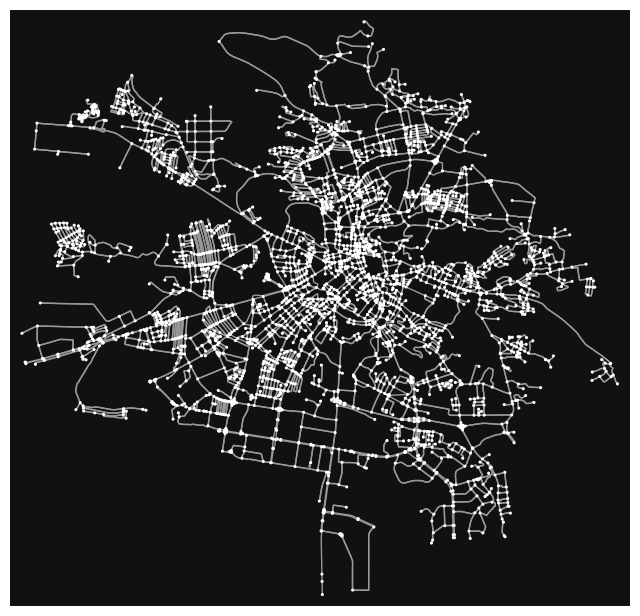

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [11]:
ox.plot_graph(G, node_size=5)

# Adding installed charging stations

**The form in which installed stations are presented:**\
$y\ =\ \{$ \
$\ \ \ \ (i, station\_capacity): n$ \
$\}$

Where\
$i$ - node_id,\
$n$ - number of stations (of this type) in the node $i$

In [12]:
def add_charging_stations(G, CS_data, visualization = True):
    charging_stations = pd.read_csv(CS_data["installed_stations"], sep = ";")
    # print(charging_stations.head())
    installed_cs = dict()
    installed_cs_list = []
    for row_index in range(len(charging_stations)):
        latitude = charging_stations['X'][row_index]
        longitude = charging_stations['Y'][row_index]
        num_of_chargers = charging_stations['Number'][row_index]
        cs_capacity = charging_stations['Capacity'][row_index]
        station_point = Point(longitude, latitude)

        # Найближче ребро (u, v, key) and its geometry
        u, v, key = ox.distance.nearest_edges(G, longitude, latitude)

        edge_data = G.get_edge_data(u, v, key)
        geom = edge_data.get("geometry", LineString([(G.nodes[u]['x'], G.nodes[u]['y']),
                                                    (G.nodes[v]['x'], G.nodes[v]['y'])]))

        # Найближча точка на ребрі
        line = LineString(geom)
        closest_point = line.interpolate(line.project(station_point))
        # new_node_id = (closest_point.x, closest_point.y)
        new_node_id = max(G.nodes) + 1
        G.add_node(new_node_id, x=closest_point.x, y=closest_point.y)

        # Поділ ребра на два ребра
        if G.has_edge(u, v, key):
            G.remove_edge(u, v, key)
            G.add_edge(u, new_node_id, length=line.project(closest_point))
            G.add_edge(new_node_id, v, length=line.length - line.project(closest_point))
        
        if G.has_edge(v, u, key):
            G.remove_edge(v, u, key)
            G.add_edge(v, new_node_id, length=line.project(closest_point))
            G.add_edge(new_node_id, u, length=line.length - line.project(closest_point))

        if new_node_id not in installed_cs_list:
            installed_cs_list.append(new_node_id)
        installed_cs[(new_node_id, cs_capacity)] = num_of_chargers

    if visualization:
        pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
        G_lviv_undirected = G.to_undirected()
        G_lviv_undirected.remove_edges_from(nx.selfloop_edges(G_lviv_undirected))
        fig, ax = plt.subplots(figsize=(12, 9), facecolor="black")

        nx.draw(G_lviv_undirected, pos, node_size=3, with_labels=False, node_color="white", edge_color="white", ax=ax)
        nx.draw_networkx_nodes(
        G_lviv_undirected, pos, nodelist=installed_cs_list, node_size=10, node_color="orange", label="Installed Stations", ax=ax)

        legend = plt.legend(scatterpoints=1, frameon=True, loc="upper right", facecolor="black", edgecolor="white", bbox_to_anchor=(1.5, 1))
        for text in legend.get_texts():
            text.set_color("white")

        plt.title("Graph with Installed Stations", color="white")
        ax.axis("off")
        fig.patch.set_facecolor("black")
        ax.set_facecolor("black")
        plt.tight_layout()
        plt.show()
    return G, installed_cs, installed_cs_list

# Capacity demand prediction

### Division into sectors

In [13]:
def division_into_secors(city_data):
    city_boundary = ox.geocode_to_gdf(city_data["place"])

    xmin, ymin, xmax, ymax = city_boundary.total_bounds
    grid_size = 0.0125

    grid_cells = []
    for x in np.arange(xmin, xmax, grid_size):
        for y in np.arange(ymin, ymax, grid_size):
            grid_cells.append(box(x, y, x + grid_size, y + grid_size))

    grid = gpd.GeoDataFrame(geometry=grid_cells, crs=city_boundary.crs)
    map_with_grid = gpd.clip(grid, city_boundary)

    # ax = map_with_grid.plot(edgecolor="rosybrown", facecolor="none", figsize=(10, 10))
    # city_boundary.boundary.plot(ax=ax, color="maroon")
    # ctx.add_basemap(ax, crs=city_boundary.crs, source=ctx.providers.CartoDB.Positron)
    return map_with_grid, city_boundary

Assigning graph nodes to a grid cell (region)

In [14]:
def nodes_to_region(G, map_with_grid):
    nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
    nodes_gdf = nodes_gdf.set_geometry(nodes_gdf.geometry)

    nodes_in_grid = gpd.sjoin(nodes_gdf, map_with_grid, how="left", predicate="within")
    nodes_in_grid = nodes_in_grid.reset_index()

    # Handling nodes that are not assigned to any grid cell. Creating node to region dictionary and region to nodes dictiionary
    assigned_nodes = nodes_in_grid.dropna(subset=['index_right']) 
    missing_nodes = nodes_in_grid[nodes_in_grid['index_right'].isna()]

    tree = cKDTree(assigned_nodes[['x', 'y']].values)
    _, nearest_idx = tree.query(missing_nodes[['x', 'y']].values)

    nodes_in_grid.loc[nodes_in_grid['index_right'].isna(), 'index_right'] = assigned_nodes.iloc[nearest_idx]['index_right'].values
    nodes_in_grid['index_right'] = nodes_in_grid['index_right'].astype(int)

    # region -> list of nodes
    region_to_nodes = nodes_in_grid.groupby(nodes_in_grid.index_right)['osmid'].apply(list).to_dict()
    # node -> region DI
    node_to_region = nodes_in_grid.set_index('osmid')['index_right'].to_dict()
    regions = [region for region in region_to_nodes]
    return regions, region_to_nodes, node_to_region


In [15]:
# map_with_grid = map_with_grid.to_crs(epsg=4326)
# edges_gdf = edges_gdf.to_crs(map_with_grid.crs)
# fig, ax = plt.subplots(figsize=(12, 10))

# map_with_grid.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.5, alpha=0.7, label="Grid")

# edges_gdf.plot(ax=ax, color="darkgray", linewidth=1, alpha=0.8, label="Road Network")
# nodes_gdf.plot(ax=ax, color="red", markersize=5, alpha=0.6, label="Nodes")

# ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)

# ax.set_title(f"Road Network and Grid Overlay in {city_data['place']}", fontsize=14)
# ax.legend()
# plt.show()


### Demand estimation for each region

In [16]:
def demand_estimation(map_with_grid, city_boundary, city_data, visualization = False):

    # Population count for each sector
    raster_file_population = city_data["raster_file_population"]
    with rasterio.open(raster_file_population) as data:
        affine = data.transform
        array = data.read(1)
    stats = zonal_stats(map_with_grid, raster_file_population, stats=["sum"], affine=affine)
    map_with_grid["population"] = [s["sum"] if s["sum"] is not None else 0 for s in stats]
    map_with_grid["density"] = map_with_grid["population"] / map_with_grid.geometry.area

    # Calculation of the number of EV for each sector
    map_with_grid["EV"] = map_with_grid["population"] *city_data["EV_per_capita"]

    # Calculation of charging capacity demand in each region
    avg_consumption_per_km = EV_data["avg_consumption_per_km"] #Wh/km
    avg_distance_per_day = EV_data["avg_distance_per_day"] #km
    energy_loss = CS_data["energy_loss"]
    station_utilization_rate = CS_data["station_utilization_rate"]

    map_with_grid["daily_energy_consumption"] = avg_consumption_per_km * avg_distance_per_day * map_with_grid["EV"]
    map_with_grid["charging_capacity_demand"] = map_with_grid["daily_energy_consumption"]/((1-energy_loss)*station_utilization_rate)

    # Creating region to capacity demand dictionary
    map_with_grid = map_with_grid.reset_index()
    region_to_capacity_demand = dict()
    for grid_cell in range(len(map_with_grid)):
        region_id = map_with_grid.iloc[grid_cell]['index']
        charging_demand = map_with_grid.iloc[grid_cell]['charging_capacity_demand']
        region_to_capacity_demand[region_id] = charging_demand

    # Visualization
    if visualization:
        ax = map_with_grid.plot(column="charging_capacity_demand", cmap="OrRd", edgecolor="rosybrown", legend=True, figsize=(12, 10), alpha =0.6)
        city_boundary.boundary.plot(ax=ax, color="maroon")
        ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)
    
    return region_to_capacity_demand

In [17]:
# ax = map_with_grid.plot(column="charging_capacity_demand", cmap="OrRd", edgecolor="rosybrown", legend=True, figsize=(12, 10), alpha =0.6)
# city_boundary.boundary.plot(ax=ax, color="maroon")
# ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)

# Distance matrix

In [18]:
def calculate_distamnce_matrix(G, nodes):
    nodes = G.nodes
    n = len(nodes)
    print(n)
    node_index = {node: idx for idx, node in enumerate(nodes)}

    D = np.full((n, n), np.inf)

    for u, v, data in G.edges(data=True):
        length = data.get("length", np.inf)
        i, j = node_index[u], node_index[v]
        D[i, j] = length

    for i in range(n): 
        D[i, i] = 0
    
    for k in range(n):
        print(k)
        for i in range(n):
            for j in range(n):
                D[i,j] = min (D[i, j], D[i, k] + D[k, j])
    return D


In [19]:
def distance_matrix(G, city_data):
    if city_data["distance_matrix"]:
        return np.load(city_data["distance_matrix"])
    return calculate_distamnce_matrix(G)

Faster method

In [20]:
from scipy.sparse.csgraph import floyd_warshall
# G = ox.graph_from_place('Dnipro, Ukraine', network_type='drive')
def distance_matrix1(G):
    nodes = list(G.nodes)
    n = len(nodes)
    print(f"Number of nodes: {n}")

    node_index = {node: idx for idx, node in enumerate(nodes)}
    print("Creating adjacency matrix")
    # Create adjacency matrix
    D = np.full((n, n), np.inf)

    for u, v, data in G.edges(data=True):
        length = data.get("length", np.inf)
        i, j = node_index[u], node_index[v]
        D[i, j] = length
        # D[j, i] = length  # Add for undirected graphs

    np.fill_diagonal(D, 0)  # Set diagonal to 0
    print("Using optimized Floyd-Warshall")
    # Use optimized Floyd-Warshall
    D = floyd_warshall(D, directed=True)  # False for undirected graphs
    np.save("distance_matrix_lviv1.npy", D)
    return D
# np.save("distance_matrix_lviv1.npy", distance_matrix1(G))


# Power grid constraints

# Simulated Annealing Algorithm

**The form in which the solution is presented:**\
$x\ =\ \{$ \
$\ \ \ \ (i, 'station\_type'): n$ \
$\}$

Where\
$i$ - node_id,\
$n$ - number of stations (of this type) in the node $i$

## Initialization

- 1 solution
- 5-100 random stations for each solution
- random cs type

In [21]:
def initialize_solution(nodes, station_types):
    solution = {}
    # solution = {(node, cs_type):0 for cs_type in station_types for node in nodes}
    # print(solution)

    for node in random.sample(nodes, k=random.randint(5, 100)):
        cs_type = random.choice(station_types)
        cs_number = random.choices([1,2,3,4], [0.3, 0.4, 0.2, 0.1])[0]
        solution[(node, cs_type)] = cs_number
    return solution

## Fitness Evaluation

### 1) CS cost evaluation

Total CS cost:\
$cs\_cost = \sum^N_{i=1}\sum_{n \in cs\_type} cost_{n,i}*X_{n,i}$

In [22]:
def cs_cost_penalty(solution, CS_data):
    total_cost = 0
    for charging_station in solution:
        cs_type = charging_station[1]
        cost = CS_data[cs_type]["cost"]
        number_of_stations = solution[charging_station]
        total_cost += cost*number_of_stations
    return total_cost

### 2) Coverage penalty evaluation

Coverage penalty takes into account how much the predicted demand for total capacity is greater than the total solution capacity, and it also takes into account how much the average distance from each node to the nearest charging station is greater than the desired maximum distance to charging stations

$coverage\_penalty = \frac{estimated\_demand}{total\_capacity} + \lambda*\frac{dist\_to\_closest\_cs}{max\_dist}$

In [23]:
def calculate_capacity_penalty(solution, region_to_capacity_demand, node_to_region, CS_data, installed_stations):

    capacity_penalty = 0
    region_total_capacity = {region: 0 for region in region_to_capacity_demand}

    # Calculating total capacity for each region
    for charging_station in solution:
        node = charging_station[0]
        cs_type = charging_station[1]
        cs_number = solution[charging_station]
        region = node_to_region[node]
        region_total_capacity[region] = region_total_capacity[region] + CS_data[cs_type]["capacity"]*cs_number

    if installed_stations:
        for charging_station in installed_stations:
            node = charging_station[0]
            cs_capacity = charging_station[1]
            cs_number = installed_stations[charging_station]
            region = node_to_region[node]
            region_total_capacity[region] = region_total_capacity[region] + cs_capacity*cs_number

    # Calculating capacity penalty
    for region in region_to_capacity_demand:
        capacity_penalty +=  region_to_capacity_demand[region]/(region_total_capacity[region]+0.001) # +0.001 to avoid division by zero
    return capacity_penalty

In [24]:
def calculate_distance_penalty(solution, nodes_dict, distance_matrix, max_distance, installed_stations):
    
    total_distance_to_stations = 0
    distance_penalty = 0 
    nodes = list(nodes_dict.keys())
    # Calculating total distance from each node to closest charging station
    for node in nodes:
        distance_list = []
        for charging_station in solution:
            cs_node = charging_station[0]
            # Using nodes_dict to determine node index in distance matrix
            distance = distance_matrix[nodes_dict[node], nodes_dict[cs_node]]
            if distance != float('inf'):
                distance_list.append(distance_matrix[nodes_dict[node], nodes_dict[cs_node]])
        
        if installed_stations:
            for charging_station in installed_stations:
                cs_node = charging_station[0]
                distance = distance_matrix[nodes_dict[node], nodes_dict[cs_node]]
                if distance != float('inf'):
                    distance_list.append(distance_matrix[nodes_dict[node], nodes_dict[cs_node]])
        if len(distance_list)>0:
            total_distance_to_stations += min(distance_list)

    # Calculating distance penalty
    distance_penalty = total_distance_to_stations/(max_distance*len(nodes))
    return distance_penalty

In [25]:
def coverage_penalty(solution, distance_matrix, region_to_capacity_demand, nodes_dict, lambda_parameter, node_to_region, max_distance, CS_data, installed_stations = None):

    capacity_penalty = calculate_capacity_penalty(solution, region_to_capacity_demand, node_to_region, CS_data, installed_stations)
    # print("Capacity penalty:", capacity_penalty)
    distance_penalty = calculate_distance_penalty(solution, nodes_dict, distance_matrix ,max_distance, installed_stations)
    # print("Distance penalty:", distance_penalty)

    penalty = capacity_penalty + lambda_parameter*distance_penalty
    # print("Total coverage penalty:", penalty)
    return penalty

### 3) Grid loss

In [26]:
def total_grid_loss(solution):
    return 1

### Evaluation function

$evaluation = \alpha*cs\_cost + \beta*coverage\_penalty + \gamma*grid\_loss$

In [27]:
def evaluate_fitness(solution, parameters, CS_data, EV_data, distance_matrix, region_to_capacity_demand, node_to_region, nodes_dict, installed_stations):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    gamma = parameters["gamma"]
    lambdaa = parameters["lambda"]

    cs_cost = cs_cost_penalty(solution, CS_data)
    # print("Cost penalty:", cs_cost)
    coverage = coverage_penalty(solution, distance_matrix, region_to_capacity_demand, nodes_dict,\
                                        lambdaa, node_to_region, EV_data["max_distance_to_charger"], CS_data, installed_stations)
    # print(coverage)
    grid_loss = total_grid_loss(solution)
    # print("Grid loss:", grid_loss)

    fitness = alpha*cs_cost + beta*coverage + gamma*grid_loss
    return fitness, alpha*cs_cost, beta*coverage, gamma*grid_loss

## Generate new solution

In [98]:
def add_random_station(solution, nodes, cs_types, max_ports_per_node):
    new_solution = solution.copy()

    # Calculating total number of cs ports in each node
    total_node_ports = {cs_node: 0 for cs_node, cs_type in new_solution}
    for station in new_solution:
        total_node_ports[station[0]] = total_node_ports[station[0]] + new_solution[station]
        
    num_of_stations = random.choices([1, 2, 3, 4, 5, 6], [0.05, 0.1, 0.15, 0.2, 0.25, 0.25])[0]
    for i in range(num_of_stations):

        # Generate random node, type 
        random_node = random.choice(nodes)
        cs_type = random.choice(cs_types)
        while random_node in total_node_ports.keys() and total_node_ports[random_node] == max_ports_per_node:
            random_node = random.choice(nodes)

        # Generate random number of ports taking into account number of existing stations in the node
        if random_node in total_node_ports.keys():
            num_of_ports = random.choice(range(0, max_ports_per_node - total_node_ports[random_node])) + 1
        else:
            num_of_ports = random.choice(range(0, max_ports_per_node)) + 1

        # Generate random number of ports taking into account number of existing stations in the node
        if (random_node, cs_type) in new_solution:
            new_solution[(random_node, cs_type)] = new_solution[(random_node, cs_type)] + num_of_ports
        else:
            new_solution[(random_node, cs_type)] = num_of_ports

        # Update num_cs_ports
        if random_node in total_node_ports.keys():
            total_node_ports[random_node] = total_node_ports[random_node] + num_of_ports
        else: 
            total_node_ports[random_node] = num_of_ports
    return new_solution

In [99]:
def remove_random_station(solution):
    new_solution = solution.copy()

    num_of_stations = random.choices([1, 2, 3, 4, 5, 6], [0.05, 0.1, 0.15, 0.2, 0.25, 0.25])[0]

    for i in range(num_of_stations):
        random_station = random.choice([station for station in new_solution])
        num_of_ports_remove = random.choice(range(0, new_solution[random_station])) + 1

        if num_of_ports_remove < new_solution[random_station]:
            new_solution[random_station] = new_solution[random_station] - num_of_ports_remove
        else:
            new_solution.pop(random_station)
    return new_solution

In [100]:
def change_station_type(solution, cs_types, max_ports_per_node):
    new_solution = solution.copy()
    num_of_stations = random.choices([1, 2, 3, 4], [0.4, 0.3, 0.2, 0.1])[0]

    for i in range(num_of_stations):
        cs_node, cs_type = random.choice([station for station in new_solution])
        # print("cs type: ", cs_type)
        # print("cs type list: ", cs_types)
        new_cs_types_list = cs_types.copy()
        new_cs_types_list.remove(cs_type)
        # print("new cs type list: ", new_cs_types_list)

        new_cs_type = random.choice(new_cs_types_list)
        if (cs_node, new_cs_type) in new_solution:
            new_solution[(cs_node, new_cs_type)] = min(max_ports_per_node, \
                                                       new_solution[(cs_node, cs_type)] + new_solution[(cs_node, new_cs_type)])
        else:
            new_solution[(cs_node, new_cs_type)] = new_solution[(cs_node, cs_type)]

        new_solution.pop((cs_node, cs_type))
    # print(new_solution)
    
    return new_solution

In [48]:
def generate_new_solution(solution, nodes, cs_types, max_ports_per_node):

    action = random.choice(["add", "remove", "change_type"])
    if action == "add":
        new_solution = add_random_station(solution, nodes, cs_types, max_ports_per_node)
    elif action == "remove":
        new_solution = remove_random_station(solution)
    else:
        new_solution = change_station_type(solution, cs_types, max_ports_per_node)

    return new_solution

## Check constraints

In [32]:
def check_constraints(_):
    return True

## Fitness plot

In [33]:
def plot_fitness(fitness_list):
    plt.figure(figsize=(7, 5))
    plt.plot(range(len(fitness_list)), fitness_list)
    plt.xlabel('Iteration')
    plt.ylabel('Best fitness')
    plt.title('Fitness value of the best solution for each iteration')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Simulated Annealing Algorithm

In [61]:
def SA_algorithm(G, dist_matrix, EV_data, CS_data, model_parameters, region_to_capacity_demand, node_to_region, installed_cs = False):
    nodes = list(G.nodes)
    nodes_dict = {nodes[i]: i for i in range(len(nodes))}
    cs_types = CS_data["CS_list"]

    current_solution = initialize_solution(nodes, cs_types)
    best_solution = current_solution

    current_fitness, fitness_cost, fitness_coverage, fitness_loss = evaluate_fitness(current_solution, model_parameters, CS_data, EV_data, dist_matrix,\
                                    region_to_capacity_demand, node_to_region, nodes_dict, installed_cs)
    best_fitness = current_fitness
    best_fitness_list = [[current_fitness, fitness_cost, fitness_coverage, fitness_loss]]

    T = model_parameters["T_initial"]
    min_T = model_parameters["T_min"]
    cooling_rate = model_parameters["cooling_rate"]
    iterations = model_parameters["iterations"]

    for iteration in range(iterations):
        print("Iteration", iteration + 1, "/", iterations)

        if T < min_T:
            break
        new_solution = generate_new_solution(current_solution, nodes, cs_types, CS_data["max_stations_num"])
        new_fitness = evaluate_fitness(new_solution, model_parameters, CS_data, EV_data, dist_matrix,\
                                    region_to_capacity_demand, node_to_region, nodes_dict, installed_cs)[0]
        delta_fitness = new_fitness - current_fitness

        if delta_fitness < 0 or (random.random() < math.exp(-delta_fitness / T)):
            current_solution = new_solution
            current_fitness = new_fitness

            if current_fitness < best_fitness:
                best_solution = current_solution
                best_fitness = current_fitness
        
        _, fitness_cost, fitness_coverage, fitness_loss = evaluate_fitness(best_solution, model_parameters, CS_data, EV_data, dist_matrix,\
                                    region_to_capacity_demand, node_to_region, nodes_dict, installed_cs)
        best_fitness_list.append([best_fitness, fitness_cost, fitness_coverage, fitness_loss])
        print(f"Best Fitness = {best_fitness}")
        T *= cooling_rate

    return best_solution, best_fitness_list

In [40]:
# def pso_algorithm(G, dist_matrix, EV_data, CS_data, model_parameters, region_to_capacity_demand, node_to_region, installed_cs = False):
#     nodes = list(G.nodes)
#     nodes_dict = {nodes[i]: i for i in range(len(nodes))}

#     particles, velocities = initialize_particles(nodes, CS_data["CS_list"], num_particle = 30)
#     p_best = particles.copy()
#     p_best_fitness = [evaluate_fitness(particle, model_parameters, CS_data, EV_data, dist_matrix,\
#                                     region_to_capacity_demand, node_to_region, nodes_dict, installed_cs)[0] for particle in particles]
#     g_best = p_best[np.argmin(p_best_fitness)]
#     g_best_fitness = min(p_best_fitness)

#     iterations = model_parameters["iterations"]

#     _, fitness_cost, fitness_coverage, fitness_loss = evaluate_fitness(g_best, model_parameters, CS_data, EV_data, dist_matrix,\
#                                     region_to_capacity_demand, node_to_region, nodes_dict, installed_cs)
#     best_fitness_list = [[g_best_fitness, fitness_cost, fitness_coverage, fitness_loss]]
    
#     for n in range(iterations):
#         print("Iteration", n + 1, "/", iterations)

#         for i in range(len(particles)):
#             velocities[i] = update_velocity(particles[i], velocities[i], p_best[i], g_best, model_parameters)
#             particles[i] = update_particle(particles[i], velocities[i], CS_data["max_stations_num"])
#             current_fitness = evaluate_fitness(particles[i], model_parameters, CS_data, EV_data, dist_matrix,\
#                                     region_to_capacity_demand, node_to_region, nodes_dict, installed_cs)[0]
            
#             if current_fitness < p_best_fitness[i]:
#                 p_best[i] = particles[i]
#                 p_best_fitness[i] = current_fitness

#             if current_fitness < g_best_fitness:
#                 g_best = particles[i]
#                 g_best_fitness = current_fitness
#         _, fitness_cost, fitness_coverage, fitness_loss = evaluate_fitness(g_best, model_parameters, CS_data, EV_data, dist_matrix,\
#                                     region_to_capacity_demand, node_to_region, nodes_dict, installed_cs)
#         best_fitness_list.append([g_best_fitness, fitness_cost, fitness_coverage, fitness_loss])
#         print(f"Best Fitness = {g_best_fitness}")
#     # plot_fitness(best_fitness_list)

#     return g_best, best_fitness_list


## Visualization

In [105]:
def visualize_solution(solution, G, installed_cs_list = None):

    cs_lists_by_type = dict()
    for charging_station in solution:
        cs_node = charging_station[0]
        cs_type = charging_station[1]
        if cs_type in list(cs_lists_by_type.keys()):
            cs_lists_by_type[cs_type].append(cs_node)
        else:
            cs_lists_by_type[cs_type] = [cs_node]


    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    G_undirected = G.to_undirected()
    G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))
    fig, ax = plt.subplots(figsize=(12, 9), facecolor="black")

    nx.draw(G_undirected, pos, node_size=5, with_labels=False, node_color="white", edge_color="white", ax=ax)
    
    # Installed stations
    if installed_cs_list:
        nx.draw_networkx_nodes(
            G_undirected, pos, nodelist=installed_cs_list, node_size=20, node_color="orange", label="Initially Installed Stations", ax=ax
        )

    for cs_type in cs_lists_by_type:
        nx.draw_networkx_nodes(
            G_undirected, pos, nodelist=cs_lists_by_type[cs_type], node_size=20, label=f"{cs_type} Stations", ax=ax
        )


    legend = plt.legend(scatterpoints=1, frameon=True, loc="upper right", facecolor="black", edgecolor="white", bbox_to_anchor=(1.5, 1))
    for text in legend.get_texts():
        text.set_color("white")

    plt.title("Graph with Stations", color="white")
    ax.axis("off")

    fig.patch.set_facecolor("black")
    ax.set_facecolor("black")

    plt.tight_layout()
    plt.show()

In [37]:
def visualize_nodes(node_list, G):

    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    G_undirected = G.to_undirected()
    G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))
    fig, ax = plt.subplots(figsize=(12, 9), facecolor="black")

    nx.draw(G_undirected, pos, node_size=1, with_labels=False, node_color="white", edge_color="white", ax=ax)

    nx.draw_networkx_nodes(
        G_undirected, pos, nodelist=node_list, node_size=30, node_color="green", label="Level 2 Stations", ax=ax
    )

    legend = plt.legend(scatterpoints=1, frameon=True, loc="upper right", facecolor="black", edgecolor="white", bbox_to_anchor=(1.5, 1))
    for text in legend.get_texts():
        text.set_color("white")

    plt.title("Graph", color="white")
    ax.axis("off")

    fig.patch.set_facecolor("black")
    ax.set_facecolor("black")

    plt.tight_layout()
    plt.show()


In [83]:
def plot_models_fitness(best_fitness_lists, parameters):
    m = len(best_fitness_lists)
    plt.figure(figsize=(15, 10))

    for i in range(m):
        
        fitness_list = best_fitness_lists[i]
        fitness = [iteration[0] for  iteration in fitness_list]
        fitness_cost = [iteration[1] for  iteration in fitness_list]
        fitness_coverage = [iteration[2] for  iteration in fitness_list]
        fitness_grid_loss = [iteration[3] for  iteration in fitness_list]
        n = len(fitness_list)

        plt.subplot((m+1)//2, 2, i+1)
        plt.plot(range(n), fitness, label = "Total evaluation")
        plt.plot(range(n), fitness_cost, label = f"Cost evaluation, weight = {parameters['alpha']}")
        plt.plot(range(n), fitness_coverage, label = f"Coverage evaluation, weight = {parameters['beta']}")
        plt.plot(range(n), fitness_grid_loss, label = f"Grid loss evaluation, weight = {parameters['gamma']}")

        plt.xlabel('Iteration')
        plt.ylabel('Best fitness')
        plt.title(f'Fitness values of the best solution for each iteration for PSO model №{i+1}')
        plt.grid(True)
        plt.legend()

    # plt.figure(figsize=(12, 7))
    # for i in range(n):
    #     plt.plot(range(len(best_fitness_lists[i])), best_fitness_lists[i], label = f"model № {i+1}")
    # plt.xlabel('Iteration')
    # plt.ylabel('Best fitness')
    # plt.title('Fitness value of the best solution for each iteration')
    # plt.grid(True)
    # plt.legend()
    plt.tight_layout()
    plt.show()

# Simulated Annealing model

In [81]:
def SA_model(city_data, EV_data, CS_data, model_parameters, n = 4):
    # Graph
    G = ox.graph_from_place(city_data["place"], network_type="drive")

    # Adding installed stations
    G, installed_cs, installed_cs_list = add_charging_stations(G, CS_data, visualization = False)

    # Calculating distance matrix
    dist_matrix = distance_matrix(G, city_data)
    # Division into sectors + demand estimation
    map_with_grid, city_boundary = division_into_secors(city_data)
    regions, region_to_nodes, node_to_region = nodes_to_region(G, map_with_grid)
    region_to_capacity_demand = demand_estimation(map_with_grid, city_boundary, city_data, visualization = False)
    
    # SA
    best_fitness_lists = []
    for i in range(n):
        best_solution, best_fitness_list = SA_algorithm(G, dist_matrix, EV_data, CS_data, model_parameters,\
                                        region_to_capacity_demand, node_to_region, installed_cs = installed_cs)
        best_fitness_lists.append(best_fitness_list)
        print(len(best_fitness_list))
    # Visualization
    plot_models_fitness(best_fitness_lists, model_parameters)
    visualize_solution(best_solution, G, installed_cs_list)
    return best_solution

C:\Users\tetia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
C:\Users\tetia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
C:\Users\tetia\AppData\Local\Temp\ipykernel_5736\822576114.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_with_grid["density"] = map_with_grid["population"] / map_with_grid.geometry.area


Iteration 1 / 500
Best Fitness = 81418364.01169044
Iteration 2 / 500
Best Fitness = 81318363.9607806
Iteration 3 / 500
Best Fitness = 81318363.9607806
Iteration 4 / 500
Best Fitness = 81318363.9607806
Iteration 5 / 500
Best Fitness = 81318363.9607806
Iteration 6 / 500
Best Fitness = 81218364.0134053
Iteration 7 / 500
Best Fitness = 81218364.0134053
Iteration 8 / 500
Best Fitness = 81218364.0134053
Iteration 9 / 500
Best Fitness = 78339256.77077958
Iteration 10 / 500
Best Fitness = 77475256.80192402
Iteration 11 / 500
Best Fitness = 76403256.82298943
Iteration 12 / 500
Best Fitness = 76403256.82298943
Iteration 13 / 500
Best Fitness = 76303256.84048559
Iteration 14 / 500
Best Fitness = 76303256.84048559
Iteration 15 / 500
Best Fitness = 75139500.13830628
Iteration 16 / 500
Best Fitness = 71557133.69846907
Iteration 17 / 500
Best Fitness = 71557133.69846907
Iteration 18 / 500
Best Fitness = 71557133.69846907
Iteration 19 / 500
Best Fitness = 71557133.69846907
Iteration 20 / 500
Best Fitn

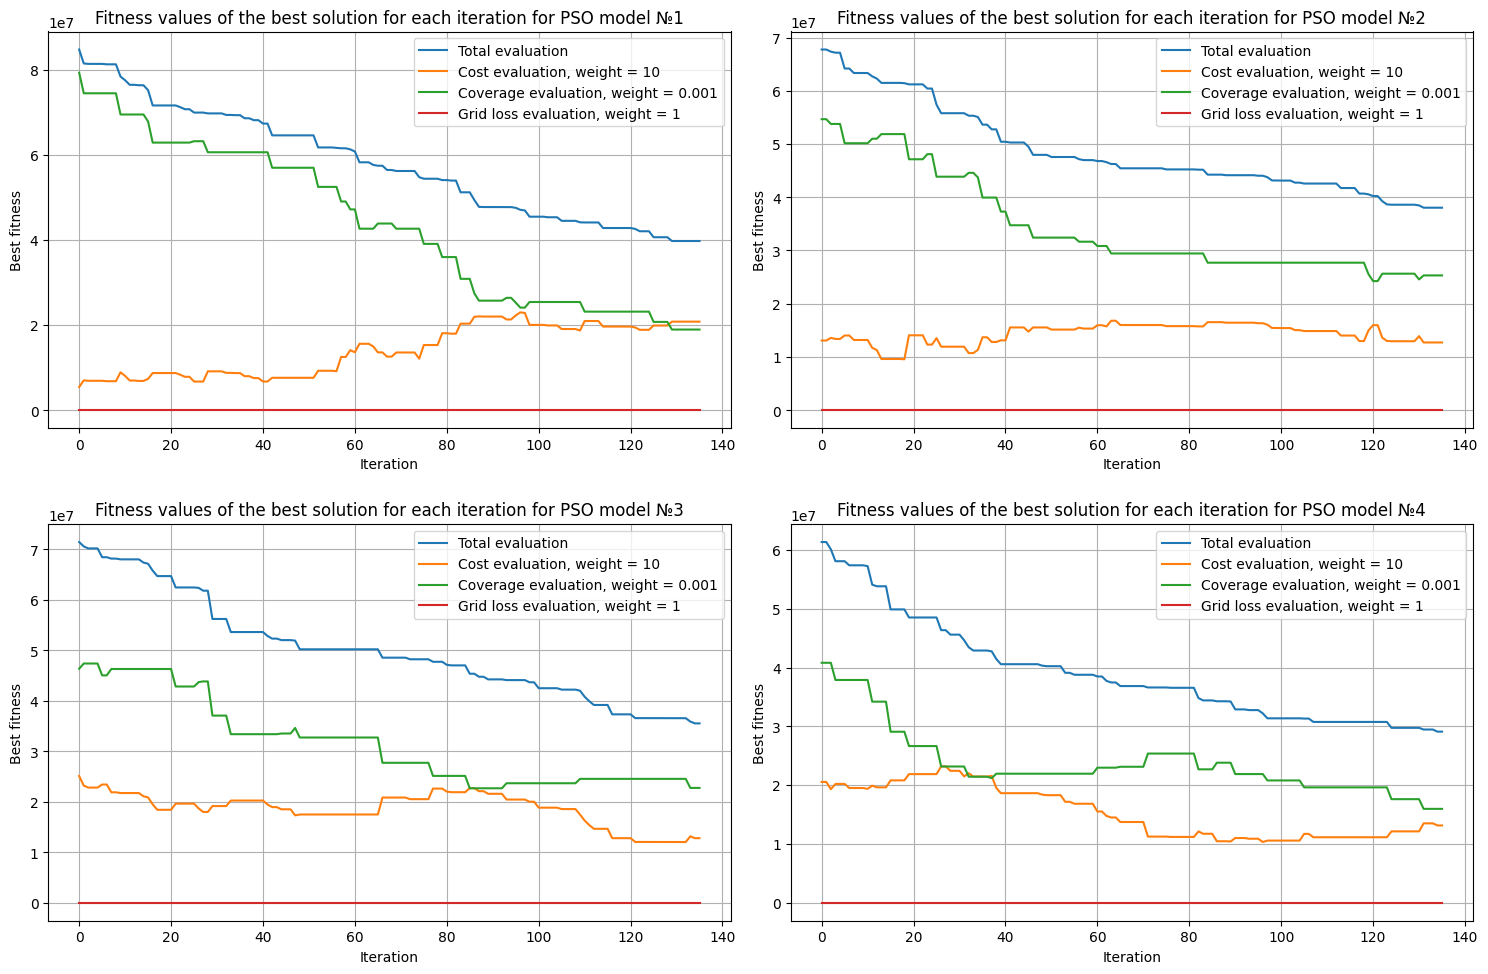

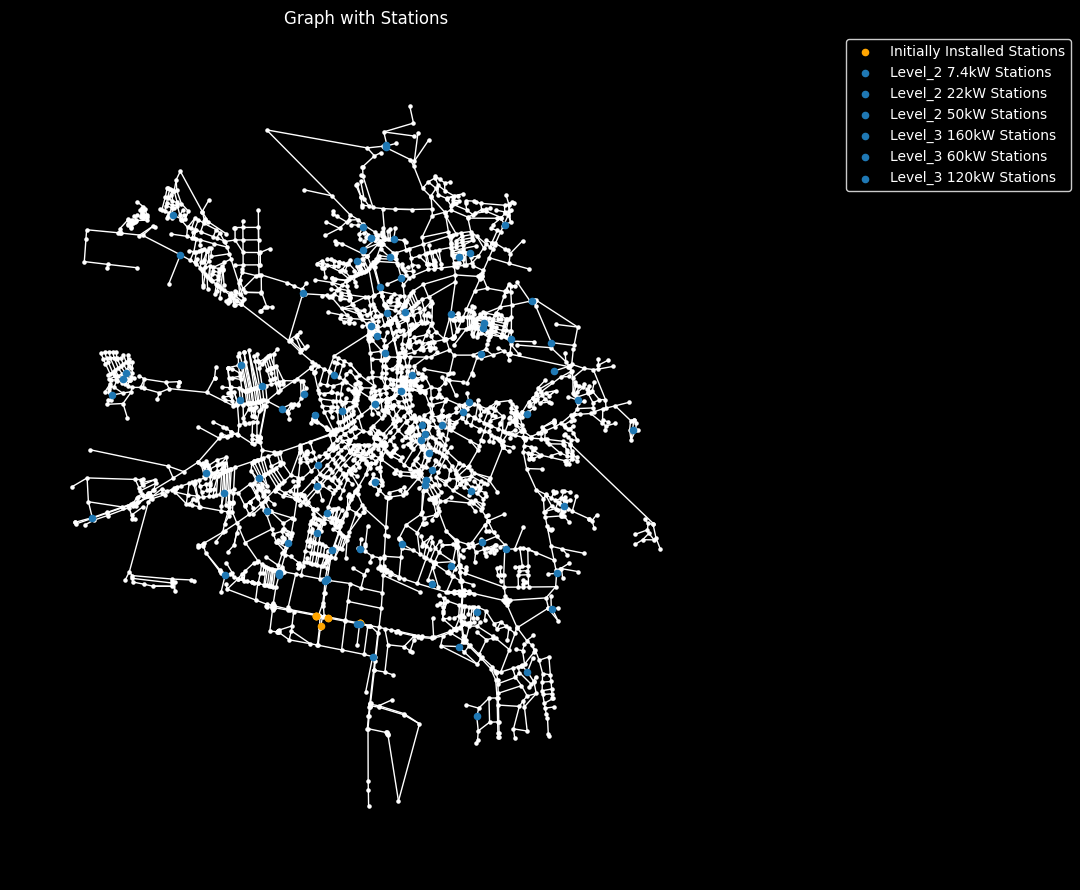

{(9172643872, 'Level_2 7.4kW'): 1,
 (1021365507, 'Level_2 22kW'): 2,
 (1882058136, 'Level_2 50kW'): 2,
 (3457347788, 'Level_2 50kW'): 4,
 (12358148378, 'Level_2 7.4kW'): 3,
 (261713135, 'Level_2 22kW'): 1,
 (1681534897, 'Level_3 160kW'): 2,
 (1982992500, 'Level_2 50kW'): 2,
 (1891394333, 'Level_2 22kW'): 2,
 (4039022955, 'Level_3 60kW'): 1,
 (1820086901, 'Level_3 120kW'): 1,
 (341101713, 'Level_2 7.4kW'): 2,
 (1625068356, 'Level_2 50kW'): 1,
 (1637092600, 'Level_2 22kW'): 2,
 (5398240283, 'Level_2 7.4kW'): 1,
 (1941194492, 'Level_3 60kW'): 2,
 (476671196, 'Level_2 50kW'): 1,
 (1631324445, 'Level_2 7.4kW'): 2,
 (1642037387, 'Level_2 22kW'): 2,
 (4589965836, 'Level_2 7.4kW'): 1,
 (4781729754, 'Level_2 7.4kW'): 2,
 (1674985548, 'Level_2 7.4kW'): 2,
 (1596335423, 'Level_3 60kW'): 2,
 (1952328451, 'Level_3 60kW'): 1,
 (8669304441, 'Level_2 22kW'): 2,
 (1281419491, 'Level_2 50kW'): 2,
 (1941186166, 'Level_2 50kW'): 3,
 (1636996474, 'Level_2 22kW'): 2,
 (4762275077, 'Level_2 50kW'): 4,
 (1935

In [106]:
SA_model(city_data, EV_data, CS_data, model_parameters, n = 4)